Granulometric Filter
=================
An implementration of the Granulometric Filter in Python. See https://imagej.net/Granulometric_Filtering.

In [33]:
import numpy as np
import numpy.fft as fft
import random as r
import scipy.cluster.vq as clust
import scipy.signal as sgnl
import scipy.ndimage as ndi
import skimage.io as io
import skimage.filters as fltrs
import skimage.feature as ftr
import matplotlib.pylab as plt
from skimage.util import random_noise
plt.gray()

<Figure size 432x288 with 0 Axes>

## Sythetic Image Creation

In [167]:
'''
Synthetic circle image creator function

imx: x size of image
imy: y size of image
amt: amount of cirles in image; default = 20
rmax: max radius of circles created

returns: nparray of image
'''
def syn_circle_img(imx=500, imy=500, amt=20, rmax=35):
    im = np.zeros((imx,imy))
    for _ in range(amt):
        cx = r.randint(0,imx)
        cy = r.randint(0,imy)
        cr = r.randint(5, rmax)
        x,y = np.meshgrid(np.arange(im.shape[0]), np.arange(im.shape[1]))
        dist = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
        im[np.where(dist < cr)] = 1
    return im

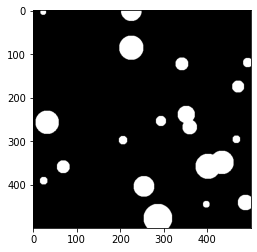

In [168]:
#rerun this cell to change image
im = syn_circle_img()
plt.imshow(im)
# binary = im < fltrs.threshold_otsu(im)

1) Perform granulometry of the image and compute G(d)
$$V[S]=\sum_{g=0}^{255} H(g)\times g \;\textrm{(H is histogram of image)}$$
$$G(d)=\frac{V[S\circ dE]-V[S\circ(d-1)E]}{V[S]}$$

2) Identify the scale of interest by the pattern of the peaks in G(d); select low bound $I_{\textrm{low}}=S\circ E_{\textrm{low}}$ and high bound images $I_{\textrm{high}}=S\circ E_{\textrm{high}}$ and subtract the images $(I_{\textrm{high}}-I_{\textrm{low}})$

 

## Granulometric Filter Function

In [163]:
def step_struct(struct, step):
    '''Dilates a struct step times for granulometric filtering'''
    # Dilate struct step times
    for i in range(step):
        # If struct has values on the edge, expand it so that values of the dilation are not truncated
        if (struct[0]+struct[-1]).sum() + (struct[:,0]+struct[:,-1]).sum() > 0:
            struct = np.pad(struct, 1)
        struct = ndi.binary_dilation(struct, struct)
    return struct

def granulometric_filter(im, struct=None, radius=9, step=1):
    '''
        im: a grayscale image
        struct: a structure for mathematical morphological computations
        radius: the smallest radius of the expected particles
        step: the step to add to radius for the largest radius of the expected particles
        retsult: image with filter applied
    '''
    # TODO: Step 1
    if struct is None or isinstance(str, struct):
        if struct == 'full':
            struct_min = ndi.generate_binary_structure(2, 2)
        else: # default is plus so struct == 'plus' falls into this block
        
        
            struct_min = ndi.generate_binary_structure(2, 1)
        struct_min = step_struct(struct_min, radius - 1) # Step struct to radius size; technically radius + 0.5
    else:
        struct_min = struct # Assumed to be correct size; radius is ignored
    struct_max = step_struct(struct_min, step)
    # Granulometry of image
    im_min = ndi.binary_opening(im, struct_min)
    im_max = ndi.binary_opening(im, struct_max)
    diff = im_min & (~im_max)
    result = ndi.binary_opening(diff, struct_min)
    # Compute G(d)


    # TODO: Step 2

    return result

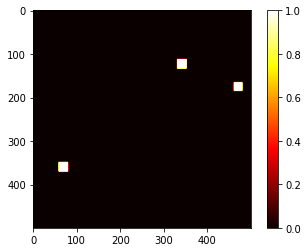

In [169]:
out = granulometric_filter(im, radius=9, step=2)
plt.imshow(out, cmap='hot')
plt.colorbar()